14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step
        Date  Actual    Predicted  Absolute_Error
0 2011-01-31    2863  2946.893555       83.893555
1 2011-02-01    3218  3129.469238       88.530762
2 2011-02-02    3343  3083.005615      259.994385
3 2011-02-03    2575  2938.777588      363.777588
4 2011-02-04    3357  2924.020264      432.979736
5 2011-02-05    2702  2912.358643      210.358643
6 2011-02-06    3338  3120.730225      217.269775
7 2011-02-07    3004  2849.789551      154.210449
8 2011-02-08    2404  3006.620117      602.620117
9 2011-02-09    3681  3117.383789      563.616211

Mean Absolute Error: 276.99


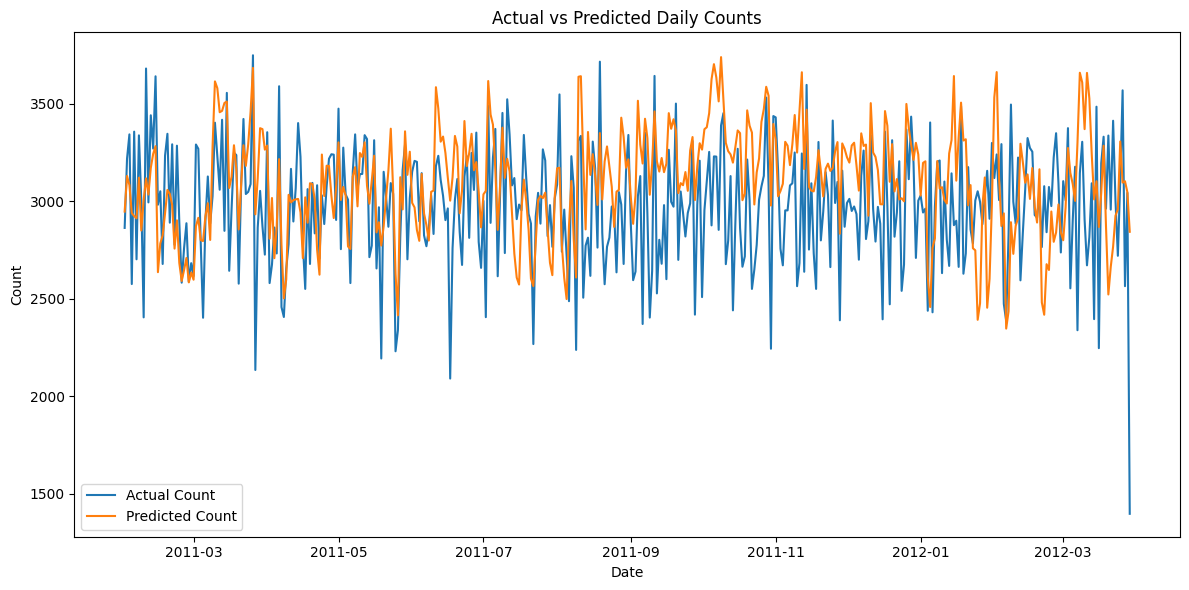

In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

model = load_model('./python/saved_lstm_model.h5')
look_back = 30

original_data = pd.read_csv('./data/ola_updated.csv')
original_data['time'] = pd.to_datetime(original_data[['year', 'month', 'day', 'hour']])
original_data.set_index('time', inplace=True)
original_data['day_of_week'] = original_data.index.weekday.map(lambda x: (x + 1) % 7)
original_data['is_weekend'] = original_data['day_of_week'].apply(lambda x: 1 if x in [0, 6] else 0)
original_data['hour_sin'] = np.sin(2 * np.pi * original_data['hour'] / 24)
original_data['hour_cos'] = np.cos(2 * np.pi * original_data['hour'] / 24)

features_cols = ['season', 'weather', 'temp', 'humidity', 'windspeed', 'hour_sin', 'hour_cos', 'day_of_week', 'is_weekend']
original_features = original_data[features_cols]
original_targets = original_data['count'].resample('D').sum().dropna()
daily_features = original_features.resample('D').mean().loc[original_targets.index]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(daily_features)
y_scaled = scaler_y.fit_transform(original_targets.values.reshape(-1, 1))

def create_sequences(X_data, look_back):
    X = []
    for i in range(len(X_data) - look_back):
        X.append(X_data[i:i + look_back])
    return np.array(X)

X_seq = create_sequences(X_scaled, look_back)

y_pred_scaled = model.predict(X_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_actual = original_targets.values[look_back:]
comparison_df = pd.DataFrame({
    'Date': original_targets.index[look_back:],
    'Actual': y_actual,
    'Predicted': y_pred.flatten()
})
comparison_df['Absolute_Error'] = np.abs(comparison_df['Actual'] - comparison_df['Predicted'])
mae = comparison_df['Absolute_Error'].mean()

print(comparison_df.head(10))
print(f'\nMean Absolute Error: {mae:.2f}')

plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Date'], comparison_df['Actual'], label='Actual Count')
plt.plot(comparison_df['Date'], comparison_df['Predicted'], label='Predicted Count')
plt.title('Actual vs Predicted Daily Counts')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()
